# FPP optimization workflow 

In [1]:
using Revise
using FUSE
using IMAS
using Plots;
FUSE.logging(Logging.Info);

## Make new FPP equilibirum from scratch

### Initialize from FPP v1_demount

In [13]:
dd = IMAS.dd()
ini, act = FUSE.case_parameters(:FPP, version=:v1_demount, init_from=:scalars);
#display(ini)

### Modify ini

In [15]:
ini.equilibrium.R0 = 4.82
ini.equilibrium.B0 = 4.71
ini.equilibrium.ip = 8e6
ini.equilibrium.ϵ = 1/3.5
ini.equilibrium.κ = 2.2
ini.equilibrium.δ = 0.7
ini.equilibrium.ζ = 0.0

ini.build.plasma_gap = 0.2
ini.build.layers[:hfs_vacuum_vessel] += ini.build.layers[:hfs_vacuum_vessel_wall_inner] + ini.build.layers[:hfs_vacuum_vessel_wall_outer]
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_outer)
ini.build.layers[:lfs_vacuum_vessel] += ini.build.layers[:lfs_vacuum_vessel_wall_inner] + ini.build.layers[:lfs_vacuum_vessel_wall_outer]
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_outer)

ini.core_profiles.impurity = :Kr
ini.core_profiles.n_shaping = 3
ini.core_profiles.T_shaping = 2.5
ini.core_profiles.T_ratio = 1/0.85
ini.core_profiles.greenwald_fraction = 1.2
ini.core_profiles.ne_ped = 1e20
ini.core_profiles.greenwald_fraction_ped = missing

ini.equilibrium.boundary_from = :scalars
ini.equilibrium.xpoints_number = 2
ini.equilibrium.field_null_surface = 0.5

ini.pf_active.n_coils_outside = 8

ini.gasc.filename = missing
ini.gasc.case = missing

ini.requirements.flattop_duration = 24*3600

display(ini)

LoadError: KeyError: key :hfs_vacuum_vessel_wall_inner not found

### Modify act

In [4]:
act.ActorEquilibrium.model = :CHEASE
act.ActorEquilibrium.symmetrize = true
act.ActorCHEASE.free_boundary = false
act.ActorCXbuild.rebuild_wall = true

act.ActorHFSsizing.do_plot = true
act.ActorHFSsizing.verbose = true
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.1
act.ActorHFSsizing.aspect_ratio_tolerance = 0.0

act.ActorEquilibriumTransport.max_iter = 8
act.ActorEquilibriumTransport.convergence_error = 1e-2
act.ActorEquilibriumTransport.do_plot = true
act.ActorTauenn.transport_model = :ds03
act.ActorTauenn.confinement_factor = 0.875
act.ActorTauenn.T_shaping = 2.5
act.ActorTauenn.temp_pedestal_ratio = 0.85
act.ActorTauenn.error = 1e-3

act.ActorPFcoilsOpt.do_plot = true
act.ActorPFcoilsOpt.symmetric = true
act.ActorPFcoilsOpt.update_equilibrium = true
act.ActorPFcoilsOpt.optimization_scheme = :currents

act.ActorPowerNeeds.model = :gasc
act.ActorPowerNeeds.bop_fraction = 0.2

act.ActorCosting.model = :Sheffield

#display(act)

LoadError: Parameter value = :gasc is not one of the valid options :thermal_power_fraction, :EU_DEMO, :FUSE

## Run WholeFacility Actor

In [5]:
dd = IMAS.dd()
@time FUSE.init(dd, ini, act; do_plot=false);
#FUSE.digest(dd)

LoadError: BoundsError: attempt to access 0-element Vector{Float64} at index [1]

### Modify dd IMAS parameters

In [6]:
dd.build.layer[8].material = "Steel, Stainless 316"
dd.build.layer[18].material = "Steel, Stainless 316"
dd.build.layer[24].material = "Steel, Stainless 316"
dd.build.tf.technology.temperature = 4.5

4.5

[ Info: Iteration = 1 , convergence error = 0.567, threshold = 0.01
[ Info: Iteration = 2 , convergence error = 0.063, threshold = 0.01
[ Info: Iteration = 3 , convergence error = 0.016, threshold = 0.01
[ Info: Iteration = 4 , convergence error = 0.002, threshold = 0.01


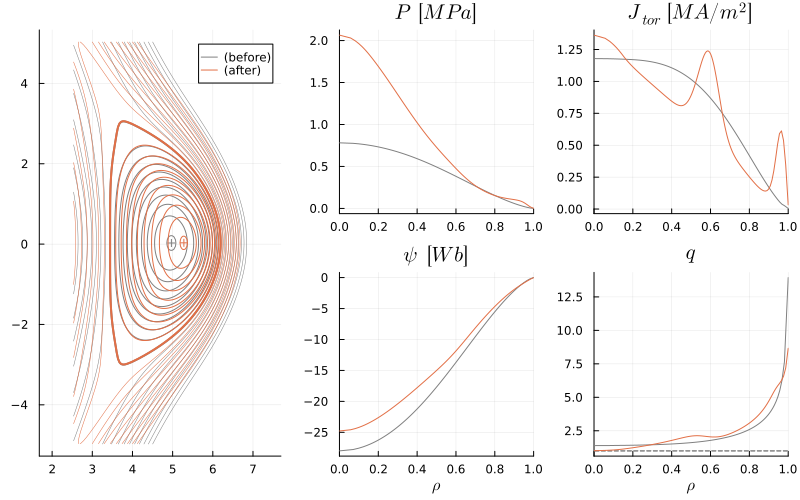

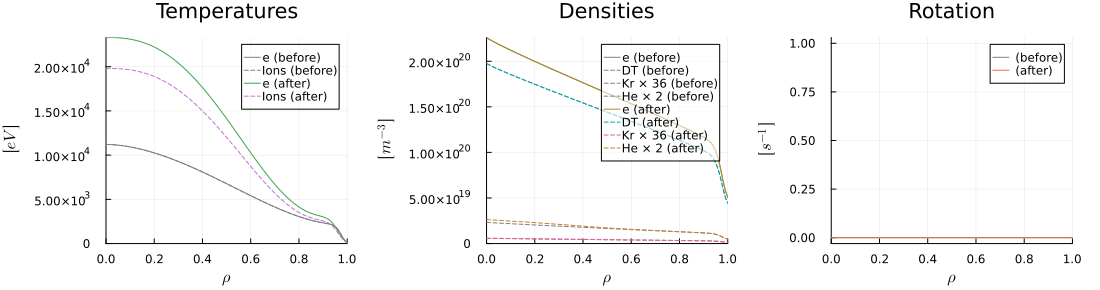

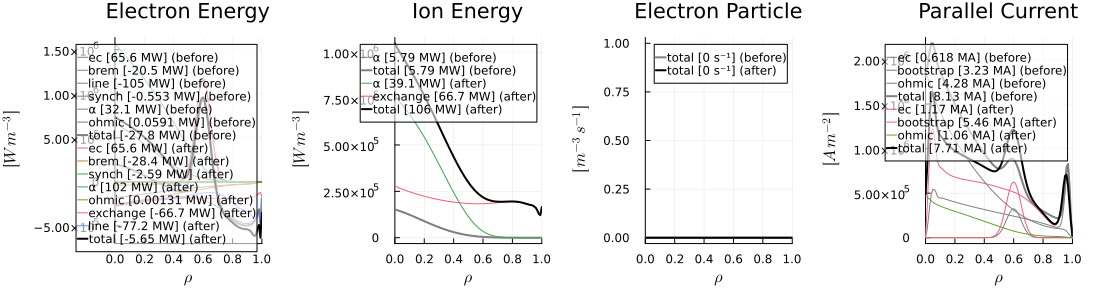

LoadError: build.layer[1].material is missing

In [7]:
@time FUSE.ActorWholeFacility(dd, act);

## Summary

In [8]:
FUSE.digest(dd)

GEOMETRY                       EQUILIBRIUM                    TEMPERATURES                   DENSITIES                      
───────────────────────────    ───────────────────────────    ───────────────────────────    ───────────────────────────    
R0 → 4.82 [m]                  B0 → 4.71 [T]                  Te0 → 23.3 [keV]               ne0 → 2.26e+20 [m⁻³]           
a → 1.38 [m]                   ip → 7.97 [MA]                 Ti0 → 19.8 [keV]               ne_ped → 1.01e+20 [m⁻³]        
1/ϵ → 3.5 [m]                  q95 → 5.54                     <Te> → 9.65 [keV]              <ne> → 1.46e+20 [m⁻³]          
κ → 2.2                        βpol → 3                       <Ti> → 8.2 [keV]               ne0/<ne> → 1.55                
δ → 0.698                      βtor → 0.0649                  Te0/<Te> → 2.41                fGW → 1.27                     
ζ → -0.0197                    βn → 5.28                      Ti0/<Ti> → 2.41                zeff_ped → 2                   


LoadError: build.layer[1].material is missing

In [9]:
display(dd.build.tf)
display(dd.build.layer[4].volume)

tf
├─ ripple ➡ Function
├─ technology
│  └─ temperature ➡ 4.5 [K]
└─ wedge_thickness ➡ Function [m]


LoadError: Bad expression build.layer[4].volume
Bad expression build.tf.wedge_thickness
build.tf.coils_n is missing

## Sanity check for TF current density

In [10]:
using Printf

R0 = dd.equilibrium.vacuum_toroidal_field.r0
B0 = dd.equilibrium.vacuum_toroidal_field.b0[1]
Itf = 5*B0*R0
Rtf_start = dd.build.layer[4].start_radius
Rtf_end = dd.build.layer[4].end_radius
Atf = pi*(Rtf_end^2-Rtf_start^2)
Atf = dd.build.tf.wedge_thickness * (Rtf_end-Rtf_start)*16
Jtf = Itf/Atf
Btf = 0.2*Itf/(Rtf_end)

fHTSinTapeTF = 1/46.54
ratioSCtoCopperTF = 1.0
fractionCableTF = (1-dd.build.tf.technology.fraction_stainless-dd.build.tf.technology.fraction_void)
fractionTapeTF = fractionCableTF * ratioSCtoCopperTF/(1+ratioSCtoCopperTF)
fractionSCTF = fHTSinTapeTF * fractionTapeTF

Jsc = Jtf/fractionSCTF

Jcrit = FUSE.YBCO_Jcrit(Btf,0.0,dd.build.tf.technology.temperature)[1]/1e6

#Jcrit_sc = 29689.9 # MA/m^2 (20K solution)
Jcrit_sc = 58345.1 # MA/m^2 (4.5K solution)

Jcrit_tf = Jcrit * fractionSCTF

@printf("R_0 = %.2f m\n",R0)
@printf("B_0 = %.2f T\n",B0)
@printf("I_TF = %.2f MA\n", Itf)
@printf("J_TF = %.2f MA/m^2\n", Jtf)
@printf("B_TF = %.2f T\n", Btf)
@printf("fractionCableTF = %.4f \n", fractionCableTF)
@printf("fractionTapeTF = %.4f \n", fractionTapeTF)
@printf("fractionSCTF = %.4f \n", fractionSCTF)

@printf("J_sc = %.2f MA/m^2\n", Jsc)
@printf("Jcrit = %.2f MA/m^2\n", Jcrit)

@printf("Jcrit_sc = %.2f MA/m^2\n", Jcrit_sc)
@printf("Jcrit_tf = %.2f MA/m^2\n", Jcrit_tf)
@printf("Jmargin_tf = %.2f \n", (Jcrit_tf-Jtf)/Jtf)
@printf("Jmargin_sc = %.2f \n", (Jcrit_sc-Jsc)/Jsc)



LoadError: Bad expression build.tf.wedge_thickness
build.tf.coils_n is missing

In [11]:
dd.balance_of_plant

balance_of_plant
├─ Q_plant ➡ Function
├─ power_electric_net ➡ Function [W]
├─ power_electric_plant_operation
│  └─ total_power ➡ Function [W]
└─ thermal_cycle
   ├─ power_electric_generated ➡ Function [W]
   └─ total_useful_heat_power ➡ Function [W]
